## Введение в анализ данных, Дз№2

Дедлайн сдачи домашнего задания: 2 ноября, 22:00. После дедлайна решения не принимаются.

В курсе “Алгоритмы интеллектуальной обработки больших объемов данных” вам необходимо реализовать алгоритм K-Means. В этом домашнем задании вам нужно будет ускорить работу программы.

Работа должна состоять из двух частей:
1. Напишите максимально быструю реализацию на python (без использования cython, numba и кода на других языках программирования). Скорее всего вам поможет векторизация вашего кода (переход от циклов к матричным вычислениям в numpy).
2. Реализуйте k-means на cython.

Помимо написания кода, нужно сделать следующее.
1. Объяснить, почему вы считаете, что быстрее сделать нельзя. Отдельно для кода на python и для кода cython. В последнем случае вам может помочь флаг -a.
2. Сравнить скорость работы различных реализаций алгоритмов.

Для тестирования используйте датасет, на котором вы проверяли работу алгоритма K-means в домашнем задании курса “Алгоритмы интеллектуальной обработки больших объемов данных”.

Домашнее задание необходимо сделать в одном jupyter notebook.

P.S. Понимаю, что в интернете существует множество уже готовых реализаций, но постарайтесь разобраться и сделать все самостоятельно. Копи-паст кода повлияет в худшую сторону на общую оценку за курс.

In [189]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.base import ClusterMixin
from tqdm import tqdm
import sys
from scipy import stats
# from scipy.spatial import distance_matrix What is difference between cdist
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

%matplotlib inline



In [191]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=10000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=221)

## Реализация через расстояние вручную

In [214]:
from scipy.spatial.distance import cdist
def dist_matrix(X, Y):
    return np.sqrt(((X[:,None, : ] - Y) ** 2).sum(-1))

def KMeans_python_slow(X, k=3, max_iter = 3, random_state = 42, EPS = 1e-6):
        np.random.seed(random_state)
        labels = np.empty(X.shape[0])
        centroids = X[np.random.choice(X.shape[0], k, replace = False)]
        for i in range(max_iter):
            centroids_last = centroids.copy()
            labels    = np.argmin(dist_matrix(X, centroids), axis=1)
            centroids = np.array([np.mean(X[labels == j], axis = 0) for j in range(k)])
            if np.mean((centroids-centroids_last)**2) < EPS:
                return labels
        return labels

###### Пример работы

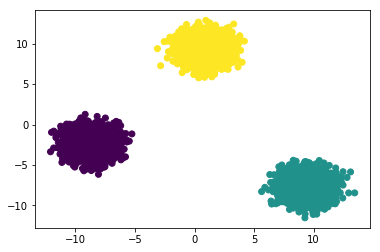

Score:	1.0
7.03 ms ± 618 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [223]:
y_test = KMeans_python_slow(X, k=3, max_iter = 100)
plt.scatter(X[:,0], X[:,1], c=y_test)
plt.show()
print("Score:\t"+str(adjusted_rand_score(y_test, y)))
%timeit KMeans_python_slow(X, k=3, max_iter = 100)

## Реализация через cdist

In [216]:
from scipy.spatial.distance import cdist
def KMeans_python(X, k=3, max_iter = 3, random_state = 42, EPS = 1e-6):
        np.random.seed(random_state)
        labels = np.empty(X.shape[0])
        centroids = X[np.random.choice(X.shape[0], k, replace = False)]
        for i in range(max_iter):
            centroids_last = centroids.copy()
            labels    = np.argmin(cdist(X, centroids), axis=1)
            centroids = np.array([np.mean(X[labels == j], axis = 0) for j in range(k)])
            if np.mean((centroids-centroids_last)**2) < EPS:
                return labels
        return labels

###### Пример работы

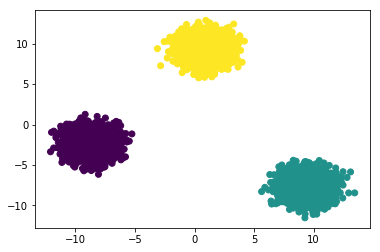

Score:	1.0
3.07 ms ± 342 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [224]:
y_test = KMeans_python(X, k=3, max_iter = 100)
plt.scatter(X[:,0], X[:,1], c=y_test)
plt.show()
print("Score:\t"+str(adjusted_rand_score(y_test, y)))
%timeit KMeans_python(X, k=3, max_iter = 100)

## Реализация через cython

In [225]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [226]:
%%cython -a
import numpy as np
cimport numpy as np
from libc.math cimport sqrt
import cython

@cython.boundscheck(False)
cpdef KMeans_cython(double[:,:] X, 
                    int k=3, 
                    int max_iter = 100, 
                    int random_state = 42,
                    double EPS = 1e-10):
        np.random.seed(random_state)
        cdef int n_object   = X.shape[0];
        cdef int n_features = X.shape[1];
        cdef long[:] y = np.zeros(n_object, dtype=np.int);
        cdef long[:] centroids_count = np.zeros(n_object, dtype=np.int);
        cdef double[:,:] centroids = np.zeros((k,n_features), dtype = np.float64);
        cdef double[:,:] centroids_prev = np.empty((k, n_features), dtype=np.float64);
        first_init = np.random.choice(range(n_object), size = k, replace=False)
        for i in range(k):
            for f in range(n_features):
                centroids[i,f] = X[first_init[i],f]

        cdef float min_dist;
        cdef int   arg_min = 666;
        cdef double S=0;
        for e in range(max_iter):
        #Save last y         
            for i in range(k):
                for d in range(n_features):
                    centroids_prev[i,d] = centroids[i,d]
        #Set y
            for i in range(n_object):
                min_dist = 9999
                arg_min = 0
                #Find min cluster
                for j in range(k):
                    S = 0
                    for f in range(n_features):
                        S += (centroids[j,f]-X[i,f])**2
                    if (S < min_dist):
                        min_dist = S
                        arg_min = j
                y[i] = arg_min 
        #Set centroids
            #Centroids <- 0
            for i in range(k):
                for f in range(n_features):
                    centroids[i,f] = 0.0
                centroids_count[i] = 0
            #Centroids       <- sum(X[label == j])
            #Centroids_count <- len(X[label]==j)
            for i in range(n_object):
                arg_min = int(y[i])
                for f in range(n_features):
                    centroids[arg_min, f] += X[i,f] 
                centroids_count[arg_min] += 1
            #Centroids = Centroids/Centoids_count
            for i in range(k):
                for f in range(n_features):
                    centroids[i,f] /= centroids_count[i]
        #Find difference between steps
            S = 0
            for i in range(k):
                for d in range(n_features):
                    S += (centroids_prev[i,d] - centroids[i,d])**2
            if S<EPS:
                return y
        return y

###### Пример работы

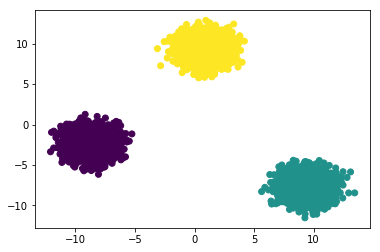

Score:	1.0
2.94 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [227]:
y_test = KMeans_cython(X, k=3, max_iter = 100)
plt.scatter(X[:,0], X[:,1], c=y_test_KMeans)
plt.show()
print("Score:\t"+str(adjusted_rand_score(y_test, y)))
%timeit KMeans_cython(X, k=3, max_iter = 100)

##### Комментарий:
Сильно быстрее сделать нельзя, все вычисления в цикле происходят на си.

Numpy переменные приводятся к типам только один раз в начале функции. 

## Сравним скорость работы на файле snsdata.csv

In [232]:
import pandas as pd
df_sns = pd.read_csv('snsdata.csv', sep=',').dropna()
df_sns.tail()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
29995,2009,M,16.115,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29996,2009,M,15.792,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29997,2009,M,15.784,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29998,2009,M,16.378,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29999,2009,F,18.724,3,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [233]:
df = df_sns.loc[:,'basketball':'drugs'].as_matrix()
X = (df - df.mean(axis=0))/df.std(axis=0)

In [236]:
print('python_slow')
%timeit -n 5 -r 10 y_test = KMeans_python_slow(X, k=9, max_iter = 1000)

print('sklearn')
model = KMeans(n_clusters=9, max_iter = 1000)
%timeit -n 5 -r 10 y_test = model.fit_predict(X)

print('python')
%timeit -n 5 -r 10 y_test = KMeans_python(X, k=9, max_iter = 1000)

print('cython')
%timeit -n 5 -r 10 y_test = KMeans_cython(X, k=9, max_iter = 1000)

python_slow
2.42 s ± 143 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)
sklearn
2.44 s ± 121 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)
python
897 ms ± 20 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)
cython
451 ms ± 10.6 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


## Вывод: 

##### на  датасете ('snsdata.csv')

|Реализация KMeans| Время работы| Во сколько раз дольше cythona |
|-----------------|-------------|-------------------------------|
|python (без numpy) | 2.42s|  5.4 |
|python (sklearn KMeans) | 2.44s|  5.4 | 
|python (c numpy) | 0.897s| 2.0 |
|cython  | 0.45s| 1.0 |

Kmeans на cythonе в 2 раза быстрее Kmeans на numpy.cdist и в 4.5 раза быстрее чем обычная python реализация и sklearn реализация (хотя в sklearn kmeans это класс, а не функция и сравнение тут не очень корректно)